<a href="https://colab.research.google.com/github/mustafabozkaya/time-series-analysis-prophet-youtube/blob/main/zaman-serisi-kaynak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis with Prophet

Prophet kütüphanesi, tek değişkenli zaman serisi veri kümeleri için tahminler yapmak için tasarlanmış açık kaynaklı bir kütüphanedir. Kullanımı kolaydır ve varsayılan olarak trendler ve mevsimsel yapıya sahip veriler için tahminler yapmak amacıyla model için iyi bir hiperparametre kümesini otomatik olarak bulmak üzere tasarlanmıştır.

## Kurulumlar

Bu projeyi gerceklestirmek icin asagidaki kutuphanelere ihtiyaciniz vardir:
- fbprophet
- pandas
- matplotlib
- plotly (Zorunlu degil fakat prophet bazi durumlarda ihtiyaci olacak)
- scikit-learn

Gerekli kutuphane kurulumlarini asagidaki kod satirini calistirarak tamamlayabilirsiniz.

`pip install fbprophet pandas matplotlib plotly scikit-learn`

## Dataset

[Monthly Car Sales Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv)

Ayni zamanda [bu linkten](https://github.com/jbrownlee/Datasets/) onlarca farkli datasete ulasabilirsiniz

## Kaynak
Machine Learning Mastery Facebook Prophet ile basit zaman serisi egitimi. [Kaynak](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)

# Baslayalim

Elimizdeki dataseti uc farkli sekilde inceleyecegiz: 
- oncelikle modelin egitildi veri seti ile egiterek modelin genel performansina bakacagiz
- elimizdeki orneklerle gelecek yil icin bir tahminde bulunacagiz
- elimizdeki verinin son bir yilini test icin ayirip bu kismi tahmin edip gercek degerler ile karsilastiracagiz

### Verinin Iceri Aktarilmasi

Aylık araba satışları veri setini kullanacağız.

Hem trend hem de mevsimsellik içeren standart bir tek değişkenli zaman serisi veri setidir. Veri kümesi 108 aylık veriye sahiptir.

In [10]:
import pandas as pd

path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

print(df.shape)


(108, 2)


In [29]:
%load_ext google.colab.data_table

In [ ]:
#%unload_ext google.colab.data_table

In [30]:
df

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026
3,1960-04-01,14395
4,1960-05-01,14587
...,...,...
103,1968-08-01,16722
104,1968-09-01,14385
105,1968-10-01,21342
106,1968-11-01,17180


### Verinin Gorsellestirilmesi

Bir zaman serisini çizmek, aslında bir trend, mevsimsel bir döngü, aykırı değerler ve daha fazlası olup olmadığını görmemize yardımcı olur. Bize veriler için bir fikir verir.

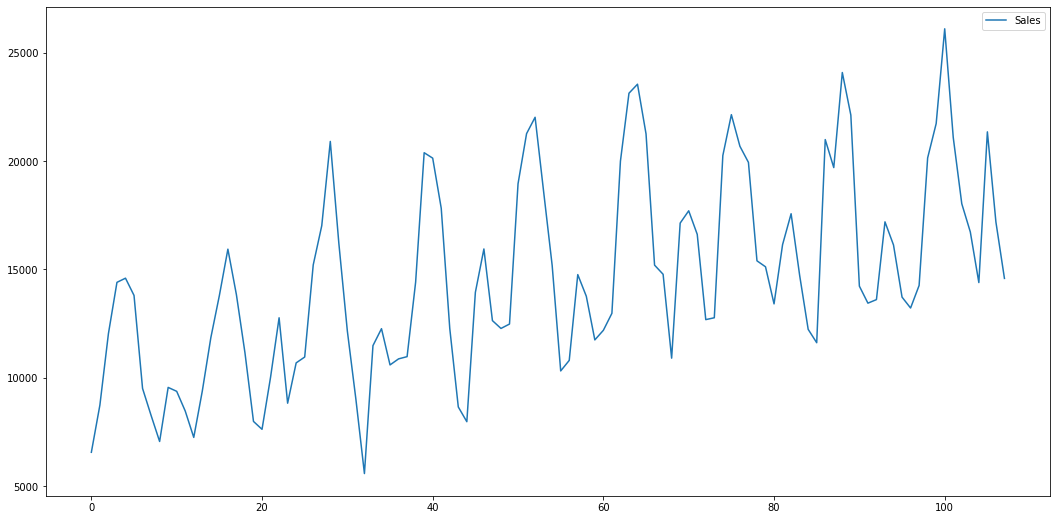

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(18,9)

df.plot()
plt.show()

Satışların zaman içindeki eğilimini ve satışlarda aylık mevsimsel bir deseni açıkça görebiliriz. Bunlar, tahmin modelinin dikkate almasını beklediğimiz kalıplardır.

### Veri Tipi Donusumu

DataFrame belirli biçimi olmalıdır. İlk sütun **ds** adına sahip olmalı ve tarih-saatleri içermelidir. İkinci sütun **y** adına sahip olmalı ve gözlemleri içermelidir.

In [21]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


### Modelin Olusturulmasi

Prophet'i tahmin için kullanmak için, önce bir Prophet() nesnesi tanımlanır ve yapılandırılır, ardından fit() işlevi çağrılarak ve veriler geçirilerek veri kümesine sığdırılır.

Model hemen hemen her şeyi otomatik olarak çözmek için çalışacaktır.

In [32]:
from fbprophet import Prophet

model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Ornek Ici Tahmin Yapmak

Geçmiş veriler üzerinden bir tahmin yapmak faydalı olabilir.

Yani, modeli eğitmek için girdi olarak kullanılan veriler üzerinde bir tahmin yapabiliriz. İdeal olarak, model verileri daha önce görmüştür ve mükemmel bir tahminde bulunur.

Buna örnek içi (eğitim kümesi örneğinde) tahmin yapmak denir ve sonuçların gözden geçirilmesi modelin ne kadar iyi olduğuna dair fikir verebilir. Yani eğitim verilerini ne kadar iyi öğrendiğidir.

predict() işlevi çağrılarak ve tahmin edilecek tüm aralıklar için 'ds' adlı bir sütun ve tarih-saat içeren satırlar içeren bir DataFrame geçirilerek bir tahmin yapılır.

Bu "tahmin" DataFrame'i yaratmanın birçok yolu vardır. Bu durumda, bir yıllık tarihler arasında döngü yapacağız, ör. veri kümesindeki son 12 ay ve her ay için bir dize oluşturun. Daha sonra tarih listesini bir DataFrame'e dönüştüreceğiz ve dize değerlerini tarih-saat nesnelerine dönüştüreceğiz.

In [33]:
future = list()

for i in range(1, 13):
    date = '1968-%.02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']


In [34]:
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)

predict() işlevinin sonucu, birçok sütun içeren bir DataFrame'dir. 

En önemli sütunlar:
- tahmin tarih saat **('ds')** 
- tahmin değeri **('yhat')** 
- tahmin edilen değerin üzerinde alt ve üst sınırları **('yhat_lower' ve 'yhat_upper')**

Örneğin, ilk birkaç tahmini şu şekilde yazdırabiliriz:

In [36]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(108)

,ds,yhat,yhat_lower,yhat_upper
0,1968-01-01,14334.737769,12737.622064,15988.296106
1,1968-02-01,14905.955964,13225.544953,16433.707229
2,1968-03-01,20842.150502,19299.087098,22456.247882
3,1968-04-01,22870.095215,21331.414315,24440.778688
4,1968-05-01,24176.211162,22702.623876,25855.038939
5,1968-06-01,21057.679190,19535.890303,22602.631406
6,1968-07-01,17585.489428,16173.529229,19171.404922
7,1968-08-01,15289.261887,13795.066130,16894.967705
8,1968-09-01,13721.438281,12128.013688,15319.206372
9,1968-10-01,18133.910877,16640.805666,19709.249049


### Tahminlerin Cizdirilmesi

Bu, modelde plot() işlevi çağrılarak ve bir sonuç DataFrame'e aktarilarak elde edilebilir. 

Asagidaki kod eğitim veri kümesinin bir grafiğini oluşturacak ve tahmin, tahmin tarihleri için üst ve alt sınırlarli gosterecektir.

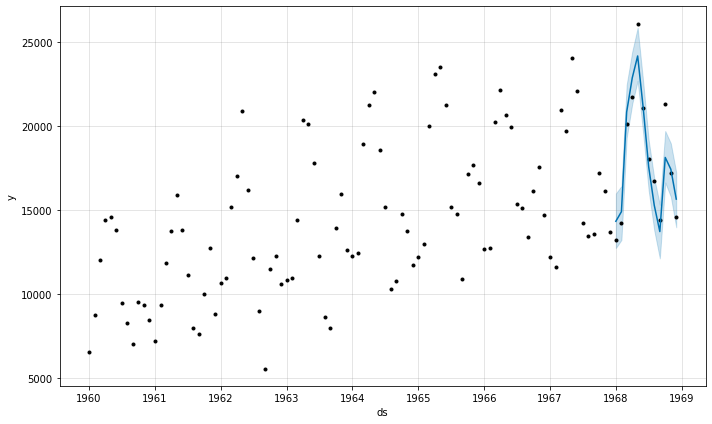

In [37]:
model.plot(forecast)
plt.show()

## Ornek Disi Tahmin Yapmak

Pratikte, eğitim verilerinin ötesinde bir tahmin yapmak için bir tahmin modeli isteriz.

Buna örnek dışı tahmin denir.

Bunu bir örnek içi tahminle aynı şekilde başarabilir ve basitçe farklı bir tahmin dönemi belirleyebiliriz.

Bu durumda, 1969-01'den başlayarak eğitim veri kümesinin sonunun ötesinde bir dönem tahmin etmeyi deneyelim.

In [38]:
future = list()

for i in range(1, 13):
    date = '1969-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(100)



,ds,yhat,yhat_lower,yhat_upper
0,1969-01-01,15375.960093,13760.624184,17020.357602
1,1969-02-01,16142.271673,14529.757274,17704.241671
2,1969-03-01,21351.832640,19768.876699,22939.124423
3,1969-04-01,23477.889811,21939.227602,25011.397959
4,1969-05-01,24988.440907,23444.550389,26535.174778
5,1969-06-01,22249.041153,20694.934511,23874.404742
6,1969-07-01,17902.329924,16275.170747,19526.818443
7,1969-08-01,15730.201800,14214.010661,17346.640179
8,1969-09-01,14235.957070,12646.508933,15737.198593
9,1969-10-01,18671.780127,17149.765520,20219.788368


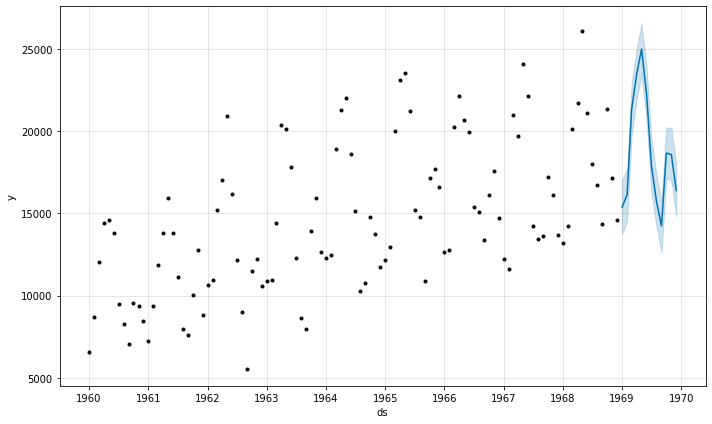

In [39]:
model.plot(forecast)
plt.show()

## Modeli Manuel Degerlendirmek

Bir tahmin modelinin performansının objektif bir tahminini geliştirmek çok önemlidir.

Bu, son 12 ay gibi bazı verileri modelden uzak tutarak başarılabilir. Ardından, modelin verilerin ilk kısmına uydurulması, tutulan paket kısmı üzerinde tahminler yapmak için kullanılması ve tahminlerdeki ortalama mutlak hata gibi bir hata ölçüsünün hesaplanması. Örneğin, simüle edilmiş bir örneklem dışı tahmin.

Skor, örneklem dışı bir tahmin yaparken modelin ortalama olarak ne kadar iyi performans göstermesini bekleyebileceğimize dair bir tahmin verir.

Bunu , son 12 ayı kaldırılmış eğitim için yeni bir DataFrame oluşturarak örnek verilerle yapabiliriz .

In [44]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

In [45]:
train = df.drop(df.index[-12:])
train.tail()

,ds,y
91,1967-08-01,13434
92,1967-09-01,13598
93,1967-10-01,17187
94,1967-11-01,16119
95,1967-12-01,13713


In [46]:
model = Prophet()
model.fit(train)

future = list()
for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

print('\n Maalesef verbose false yapamiyoruz :/ \n')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Maalesef verbose false yapamiyoruz :/ 



In [47]:
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values

In [48]:
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)


MAE: 1336.814


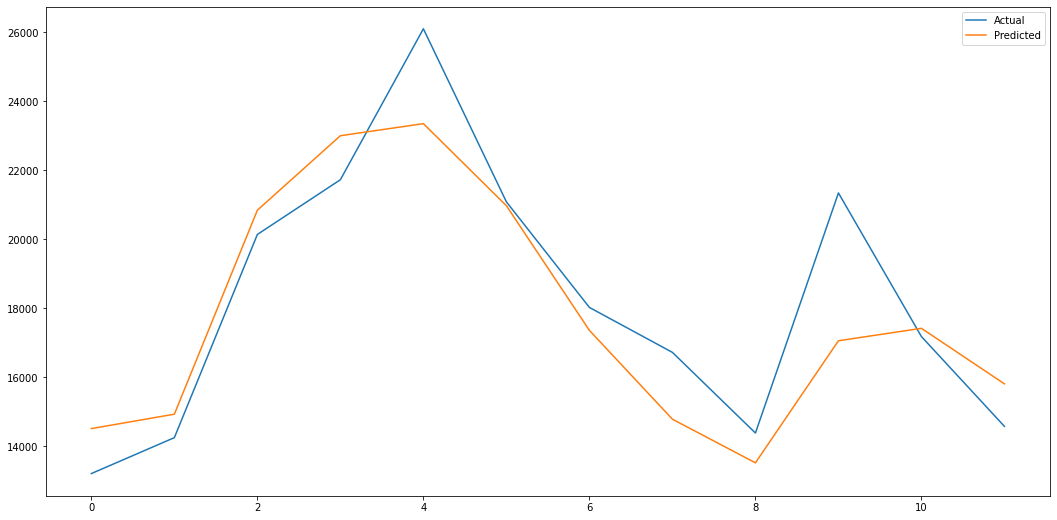

In [49]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

## Harika!